In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
## Nome dos paths onse estão salvos e vamos salvar os dados processados
PATH_FAIXA_ETARIAS = '../dados/faixa_etaria/' # Nome do path dos arquivos salvos
PATH_DADOS_PROCESSADOS = '../dados/e_sus_processados/' # Nome do path a salvar os arquivos
PATH_ESTADO = '../dados/municipios/'

FILENAME_PROCESSADOS = 'sp_sus_processados.csv' # Nome do arquivo aonde vamos salvar o arquivo
FILENAME_FAIXA_ETARIAS = 'faixa_etaria_processada.csv'
FILENAME_ESTADO = 'estados_processada.csv'

dfEstado = pd.read_csv(PATH_ESTADO + FILENAME_ESTADO, encoding='utf-8', delimiter=';')
dfFE = pd.read_csv(PATH_FAIXA_ETARIAS + FILENAME_FAIXA_ETARIAS, encoding='utf-8', delimiter=';')
dfProc = pd.read_csv(PATH_DADOS_PROCESSADOS + FILENAME_PROCESSADOS, encoding='utf-8', delimiter=';', compression='zip')

A base com a populacao dividida em faixa etária é tratada para que numa mesma coluna fiquem o população total, segmentada pelo estado e pela faixa etária a qual pertencem

In [4]:
dfFETab = (dfFE.set_index('idadeTrunc').T
    .reset_index()
    .rename(columns={'index': 'uf'})
    .set_index('uf')
    .stack()
)

dfFETab.name = 'populacao'
dfFETab = dfFETab.reset_index().set_index(['idadeTrunc', 'uf'])
dfFETab

,,populacao
idadeTrunc,uf,
0,AC,167847
10,AC,182031
20,AC,163955
30,AC,136541
40,AC,104798
...,...,...
50,TO,150266
60,TO,95910
70,TO,51374


In [5]:
dfEstado = dfEstado[['codigo_uf', 'uf', 'estado_normalizado']].set_index('estado_normalizado')

In [6]:
dfIdadeEstado = dfProc[['extractDate', 'idadeTrunc', 'estado_normalizado']].copy()

In [18]:
# dfEstado

,codigo_uf,uf
estado_normalizado,,
rondonia,11,RO
acre,12,AC
amazonas,13,AM
roraima,14,RR
para,15,PA
amapa,16,AP
tocantins,17,TO
maranhao,21,MA
piaui,22,PI


### Cruzamento dos dados com informações dos estados

O intuito desse cruzamento e a homogenização dos dados com a informação geográfica e nomeclatura dos estados. 

In [7]:
dfIdEst = dfIdadeEstado.join(dfEstado, on = ['estado_normalizado'])

In [8]:
dfIdEst

,extractDate,idadeTrunc,estado_normalizado,codigo_uf,uf
0,2020-05-15,40,sao paulo,35,SP
1,2020-03-12,50,sao paulo,35,SP
2,2020-07-10,30,sao paulo,35,SP
3,2020-05-12,60,sao paulo,35,SP
4,2020-06-24,30,sao paulo,35,SP
...,...,...,...,...,...
1130981,2020-11-16,50,sao paulo,35,SP
1130982,2020-09-03,0,sao paulo,35,SP
1130983,2020-10-13,60,sao paulo,35,SP
1130984,2020-11-11,60,sao paulo,35,SP


Agrupamento dos casos de Covid-19 por estado e faixa estária

In [31]:
################################
# Agrupamento por Idade e Estado
################################

dfGroupIdEst = (dfIdEst[['idadeTrunc', 'extractDate', 'uf']]
         .groupby(['idadeTrunc', 'uf']).agg('count')
         .reset_index()
         .rename(columns={'extractDate': 'soma_casos_covid'})
         .set_index(['idadeTrunc', 'uf'])
        )

################################
# Normalização do total de casos com a população do usuário
################################

dfFinalIdEst = dfGroupIdEst.join(dfFETab, on = ['idadeTrunc', 'uf'])
dfFinalIdEst['norm'] = dfFinalIdEst['soma_casos_covid'].div(dfFinalIdEst['populacao'])
dfFinalIdEst['norm_x1000Hab'] = dfFinalIdEst['soma_casos_covid'].div(dfFinalIdEst['populacao'])*1000
dfFinalIdEst

,,soma_casos_covid,populacao,norm,norm_x1000Hab
idadeTrunc,uf,,,,
0,SP,28594,6080459,0.004703,4.702606
10,SP,54928,6084800,0.009027,9.027084
20,SP,203387,6959603,0.029224,29.223937
30,SP,283994,7664143,0.037055,37.054893
40,SP,243397,6690421,0.036380,36.379923
50,SP,167782,5536927,0.030302,30.302368
60,SP,91751,4047400,0.022669,22.669121
70,SP,39963,2148136,0.018604,18.603571
80,SP,15096,871492,0.017322,17.322018


Probabilidade de ter COVID pertencendo a certa Faixa Etária

In [6]:
# dfProb = dfProc.groupby('idadeTrunc')
# dfProb = (dfProc[['idadeTrunc', 'extractDate']].groupby('idadeTrunc').agg('count')
#           .reset_index().rename(columns={'extractDate': 'soma'}))

# dfProb['Probabilidade_covid_and_idade'] = dfProb['soma'].div(dfProb['soma'].sum())
# dfProb['idadeTrunc'] = dfProb['idadeTrunc'].astype(int)
# dfProb = dfProb.set_index('idadeTrunc')

,,soma_casos_covid,populacao,norm,norm_x1000Hab
idadeTrunc,uf,,,,
0,SP,28594,6080459,0.004703,4.702606
10,SP,54928,6084800,0.009027,9.027084
20,SP,203387,6959603,0.029224,29.223937
30,SP,283994,7664143,0.037055,37.054893
40,SP,243397,6690421,0.036380,36.379923
50,SP,167782,5536927,0.030302,30.302368
60,SP,91751,4047400,0.022669,22.669121
70,SP,39963,2148136,0.018604,18.603571
80,SP,15096,871492,0.017322,17.322018


In [40]:
# dfFESum = dfFE[['idadeTrunc', 'SP']].copy()
# dfSum['idadeTrunc'] = dfSum['idadeTrunc'].astype(int)
# dfSum['Probabilidade_idade'] = (dfSum['SP'] / dfSum['SP'].sum())
# dfSum = dfSum.set_index('idadeTrunc')

In [39]:
# dfFinal = dfProb.join(dfSum, on=['idadeTrunc'], rsuffix = '_sum', how='outer')
# dfFinal['Probabilidade_covid_dada_idade'] = dfFinal['Probabilidade_covid_and_idade'].div(dfFinal['Probabilidade_idade'])
# dfFinal['norm'] = dfFinal['soma'].div(dfFinal['SP'])
# dfFinal['norm_x1000Hab'] = dfFinal['soma'].div(dfFinal['SP'])*1000
# dfFinal

In [38]:
# dfTeste = dfFinal[['Probabilidade_idade']]
# dfTeste.plot(kind='bar', stacked=True, rot=0)

In [33]:
################################
# Agrupamento por Idade, Data do caso e estado
################################

dfGroupIdEstData = (dfIdEst[['idadeTrunc', 'extractDate', 'uf']]
         .groupby(['idadeTrunc', 'extractDate', 'uf']).size()
         .reset_index(name='soma_casos_covid')
         .set_index(['idadeTrunc', 'uf'])
        )

dfGroupIdEstData
################################
# Normalização do total de casos com a população do usuário
################################

dfFinalIdEstData = dfGroupIdEstData.join(dfFETab, on = ['idadeTrunc', 'uf'])
dfFinalIdEstData['norm'] = dfFinalIdEstData['soma_casos_covid'].div(dfFinalIdEstData['populacao'])
dfFinalIdEstData['norm_x1000000Hab'] = dfFinalIdEstData['soma_casos_covid'].div(dfFinalIdEstData['populacao'])*1000000
dfFinalIdEstData

extractDate  soma_casos_covid  populacao          norm  \
idadeTrunc uf                                                          
0          SP  2020-03-12                 1    6080459  1.644613e-07   
           SP  2020-03-13                 1    6080459  1.644613e-07   
           SP  2020-03-14                 2    6080459  3.289225e-07   
           SP  2020-03-16                 2    6080459  3.289225e-07   
           SP  2020-03-17                 4    6080459  6.578451e-07   
...                   ...               ...        ...           ...   
90         SP  2020-11-13                 1     205952  4.855500e-06   
           SP  2020-11-14                 1     205952  4.855500e-06   
           SP  2020-11-15                 1     205952  4.855500e-06   
           SP  2020-11-16                 4     205952  1.942200e-05   
           SP  2020-11-18                 1     205952  4.855500e-06   

               norm_x1000000Hab  
idadeTrunc uf                    
0          SP          0.164461  
           SP          0.164461  
           SP          0.328923  
           SP          0.328923  
           SP          0.657845  
...                         ...  
90         SP          4.855500  
           SP          4.855500  
           SP          4.855500  
           SP         19.422001  
           SP          4.855500  

[2521 rows x 5 columns]

In [43]:
# dfPorDia = dfProc.groupby(['extractDate', 'idadeTrunc']).size().reset_index(name='counts')
# dfPorDia = dfPorDia.join(dfSum, on=['idadeTrunc'], rsuffix = '_sum', how='outer')

# dfPorDia['norm_x100000Hab'] = dfPorDia['counts'].div(dfPorDia['SP'])*1000000
# dfPorDia = dfPorDia[['extractDate', 'idadeTrunc', 'norm_x100000Hab']]

/home/german.salazar/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


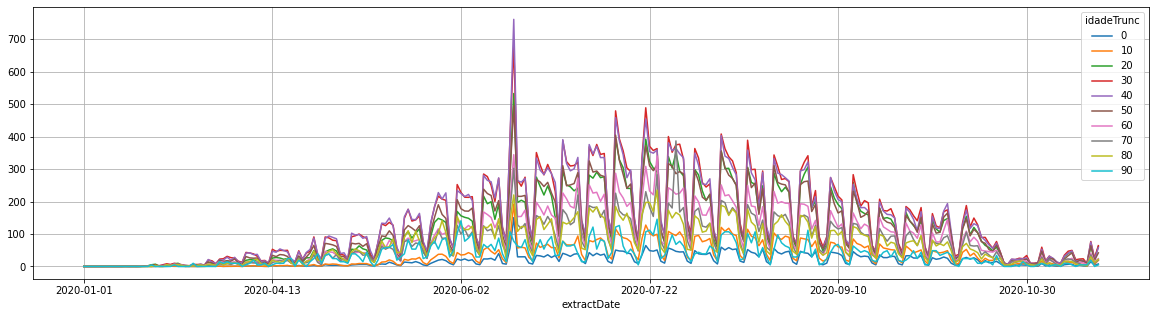

In [37]:
dffinal = pd.pivot_table(dfFinalIdEstData, values='norm_x1000000Hab', index=['extractDate'],
                    columns=['idadeTrunc'], aggfunc=np.sum, fill_value=0)
dffinal.plot(kind='line',figsize=(20,5))
plt.grid()

In [ ]:
Classificação por casos de Covid e Faixa etária 

Eixo Y Numero Total de casos normalizados, 
Eixo X Densidade Populacional
Pontinho classificador pela cor -> Casos de Covid por faixa

In [103]:
Modelo regresional

População eixo X
Numero de casos Y

Segmentação por Idade. mostrar um gráfico por idade

SyntaxError: invalid syntax (<ipython-input-103-4428a30d7f65>, line 1)